**Problem Statement** <p>
LTFS provides it’s loan services to its customers and is interested in selling more of its Top-up loan services to its existing customers so they have decided to identify when to pitch a Top-up during the original loan tenure.  If they correctly identify the most suitable time to offer a top-up, this will ultimately lead to more disbursals and can also help them beat competing offerings from other institutions. </p>
<p>LTFS  has tasked us with building a model given the Top-up loan bucket of 128655 customers along with demographic and bureau data, to predict the right bucket/period for 14745 customers in the test data.

**Import Libraries and load data files**

In [1]:
#import necessary libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Enable maximum rows and column for dataset

pd.pandas.set_option('display.max_rows',None)
pd.pandas.set_option('display.max_columns',None)

In [3]:
#load train files in dataframe

df_br = pd.read_excel('Train/train_bureau.xlsx')
df_data = pd.read_excel('Train/train_Data.xlsx')

In [5]:
#load test files in dataframe

test_df_br = pd.read_excel('Test/Test_bureau.xlsx')
test_df_data = pd.read_excel('Test/Test_Data.xlsx')

In [6]:
#Show the shape of each data frame
print('Train Bureau data shape', df_br.shape)
print('Train demographic data shape', df_data.shape)
print('Test Bureau data shape', test_df_br.shape)
print('Test demographic data shape', test_df_data.shape)

Train Bureau data shape (560844, 25)
Train demographic data shape (128655, 26)
Test Bureau data shape (64019, 25)
Test demographic data shape (14745, 25)


In [7]:
#train_bureau data head
df_br.head(3)

,ID,SELF-INDICATOR,MATCH-TYPE,ACCT-TYPE,CONTRIBUTOR-TYPE,DATE-REPORTED,OWNERSHIP-IND,ACCOUNT-STATUS,DISBURSED-DT,CLOSE-DT,LAST-PAYMENT-DATE,CREDIT-LIMIT/SANC AMT,DISBURSED-AMT/HIGH CREDIT,INSTALLMENT-AMT,CURRENT-BAL,INSTALLMENT-FREQUENCY,OVERDUE-AMT,WRITE-OFF-AMT,ASSET_CLASS,REPORTED DATE - HIST,DPD - HIST,CUR BAL - HIST,AMT OVERDUE - HIST,AMT PAID - HIST,TENURE
0,1,False,PRIMARY,Overdraft,NAB,2018-04-30,Individual,Delinquent,2015-10-05,NaN,2018-02-27,NaN,"37,352",NaN,"37,873",NaN,"37,873",0.0,Standard,"20180430,20180331,",030000,"37873,12820,","37873,,",",,",NaN
1,1,False,PRIMARY,Auto Loan (Personal),NAB,2019-12-31,Individual,Active,2018-03-19,NaN,2019-12-19,NaN,"44,000","1,405/Monthly","20,797",F03,NaN,0.0,Standard,"20191231,20191130,20191031,20190930,20190831,2...",0000000000000000000000000000000000000000000000...,"20797,21988,23174,24341,25504,26648,27780,2891...",",,,,,,,,,,,,,,,,,,,,1452,,",",,,,,,,,,,,,,,,,,,,,,,",36.0
2,1,True,PRIMARY,Tractor Loan,NBF,2020-01-31,Individual,Active,2019-08-30,NaN,NaT,NaN,"1,45,000",NaN,"1,16,087",NaN,0,0.0,NaN,"20200131,20191231,20191130,20191031,20190930,2...",000000000000000000,"116087,116087,145000,145000,145000,145000,","0,0,0,0,0,0,",",,,,,,",NaN


In [8]:
#train_demographic data head
df_data.head(3)

,ID,Frequency,InstlmentMode,LoanStatus,PaymentMode,BranchID,Area,Tenure,AssetCost,AmountFinance,DisbursalAmount,EMI,DisbursalDate,MaturityDAte,AuthDate,AssetID,ManufacturerID,SupplierID,LTV,SEX,AGE,MonthlyIncome,City,State,ZiPCODE,Top-up Month
0,1,Monthly,Arrear,Closed,PDC_E,1,NaN,48,450000,275000.0,275000.0,24000.0,2012-02-10,2016-01-15,2012-02-10,4022465,1568,21946,61.11,M,49.0,35833.33,RAISEN,MADHYA PRADESH,464993.0,> 48 Months
1,2,Monthly,Advance,Closed,PDC,333,BHOPAL,47,485000,350000.0,350000.0,10500.0,2012-03-31,2016-02-15,2012-03-31,4681175,1062,34802,70.00,M,23.0,666.67,SEHORE,MADHYA PRADESH,466001.0,No Top-up Service
2,3,Quatrly,Arrear,Active,Direct Debit,1,NaN,68,690000,519728.0,519728.0,38300.0,2017-06-17,2023-02-10,2017-06-17,25328146,1060,127335,69.77,M,39.0,45257.00,BHOPAL,MADHYA PRADESH,462030.0,12-18 Months


---

**Before going further, let's study the target variable first**

In [9]:
#target variable 
df_data['Top-up Month'].value_counts()

No Top-up Service    106677
 > 48 Months           8366
36-48 Months           3656
24-30 Months           3492
30-36 Months           3062
18-24 Months           2368
12-18 Months           1034
Name: Top-up Month, dtype: int64

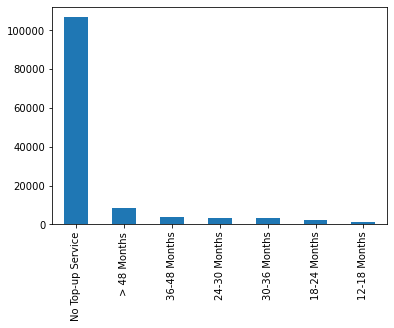

In [10]:
#visualize
df_data['Top-up Month'].value_counts().plot(kind='bar')

**Observation -** This looks like a multiclass classification task where a particular variable (No Top-up Service) is dominating

<h2> Operation 1 - NULL 

**Check for null values**

In [11]:
#check for bureau data nulls more than 50%
col_wid_nul=[] #variable: where we'll store column names which has large null values 

for col in df_br.columns:
    if df_br[col].isnull().sum()/len(df_br) > 0.5:
        print(col, '----', round((df_br[col].isnull().sum()/len(df_br))*100,2),'%')
        col_wid_nul.append(col)

LAST-PAYMENT-DATE ---- 56.93 %
CREDIT-LIMIT/SANC AMT ---- 97.3 %
INSTALLMENT-AMT ---- 74.98 %
INSTALLMENT-FREQUENCY ---- 75.8 %
ASSET_CLASS ---- 53.56 %
TENURE ---- 65.63 %


**Action -** Drop the columns with larger Null values from both train and test set of Bereau data 

In [12]:
df_br.drop(col_wid_nul,axis=1,inplace=True) #Train data
test_df_br.drop(col_wid_nul,axis=1,inplace=True) #test data

**Check the same in demographic data for NULL> 50%**

In [13]:
#for demographic data nulls more than 50%
for col in df_data.columns:
    if df_data[col].isnull().sum()/len(df_data) > 0.5:
        print(col, '----', round(df_data[col].isnull().sum()/len(df_data),2))

No Null values >50% in demographic data

<h2> Operation 2 - Drop some complex text fields from bureau data 

In [14]:
#Droping aditional complex text fields REPORTED DATE - HIST,DPD - HIST,CUR BAL - HIST,AMT OVERDUE - HIST,AMT PAID - HIST
df_br.drop(columns=['REPORTED DATE - HIST','DPD - HIST','CUR BAL - HIST',
                    'AMT OVERDUE - HIST','AMT PAID - HIST'],axis =1, inplace = True) #Train set

In [15]:
test_df_br.drop(columns=['REPORTED DATE - HIST','DPD - HIST','CUR BAL - HIST',
                    'AMT OVERDUE - HIST','AMT PAID - HIST'],axis =1, inplace = True) #Test set

<h2> Operation 3 - Check the data types and performed possible type casting

In [16]:
#checking datatype of the dataset bureau
df_br.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 560844 entries, 0 to 560843
Data columns (total 15 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   ID                         560844 non-null  int64         
 1   SELF-INDICATOR             560844 non-null  bool          
 2   MATCH-TYPE                 560844 non-null  object        
 3   ACCT-TYPE                  560844 non-null  object        
 4   CONTRIBUTOR-TYPE           560844 non-null  object        
 5   DATE-REPORTED              557161 non-null  datetime64[ns]
 6   OWNERSHIP-IND              560844 non-null  object        
 7   ACCOUNT-STATUS             560844 non-null  object        
 8   DISBURSED-DT               528694 non-null  datetime64[ns]
 9   CLOSE-DT                   309086 non-null  object        
 10  DISBURSED-AMT/HIGH CREDIT  560844 non-null  object        
 11  INSTALLMENT-AMT            140335 non-null  object  

**Converting DISBURSED-AMT/HIGH CREDIT, CURRENT-BAL and OVERDUE-AMT to numeric field**

In [17]:
#remove comma from column
df_br['DISBURSED-AMT/HIGH CREDIT'] = df_br['DISBURSED-AMT/HIGH CREDIT'].apply(lambda x: re.sub(re.compile("[,]"), "", x))

#fill the null value with 0
df_br['CURRENT-BAL'].fillna('0', inplace =True)
df_br['OVERDUE-AMT'].fillna('0', inplace =True)

#remove , from column
df_br['CURRENT-BAL'] = df_br['CURRENT-BAL'].apply(lambda x: re.sub(re.compile("[,]"), "", x))
df_br['OVERDUE-AMT'] = df_br['OVERDUE-AMT'].apply(lambda x: re.sub(re.compile("[,]"), "", x))

#convert to numeric
df_br['DISBURSED-AMT/HIGH CREDIT'] = pd.to_numeric(df_br['DISBURSED-AMT/HIGH CREDIT'])
df_br['CURRENT-BAL'] = pd.to_numeric(df_br['CURRENT-BAL'])
df_br['OVERDUE-AMT'] = pd.to_numeric(df_br['OVERDUE-AMT'])

Test set

In [18]:
#fill the null value with 0
test_df_br['DISBURSED-AMT/HIGH CREDIT'].fillna('0', inplace =True)
test_df_br['CURRENT-BAL'].fillna('0', inplace =True)
test_df_br['OVERDUE-AMT'].fillna('0', inplace =True)

#remove comma from column
test_df_br['DISBURSED-AMT/HIGH CREDIT'] = test_df_br['DISBURSED-AMT/HIGH CREDIT'].apply(lambda x: re.sub(re.compile("[,]"), "", x))
test_df_br['CURRENT-BAL'] = test_df_br['CURRENT-BAL'].apply(lambda x: re.sub(re.compile("[,]"), "", x))
test_df_br['OVERDUE-AMT'] = test_df_br['OVERDUE-AMT'].apply(lambda x: re.sub(re.compile("[,]"), "", x))

#convert to numeric
test_df_br['DISBURSED-AMT/HIGH CREDIT'] = pd.to_numeric(test_df_br['DISBURSED-AMT/HIGH CREDIT'])
test_df_br['CURRENT-BAL'] = pd.to_numeric(test_df_br['CURRENT-BAL'])
test_df_br['OVERDUE-AMT'] = pd.to_numeric(test_df_br['OVERDUE-AMT'])

## Check values in each categorical columns

In [19]:
#check values in each categorical columns of bureau data

for var in df_br.columns:
    if df_br[var].dtype == 'O' and var!='CLOSE-DT' and var!='CREDIT-LIMIT/SANC AMT':
        print(df_br[var].value_counts())
        print('\n')

PRIMARY      560647
SECONDARY       197
Name: MATCH-TYPE, dtype: int64


Tractor Loan                                                           186242
Gold Loan                                                               91024
Business Loan Priority Sector  Agriculture                              80084
Kisan Credit Card                                                       33369
Auto Loan (Personal)                                                    29575
Other                                                                   27226
Commercial Vehicle Loan                                                 19522
Two-Wheeler Loan                                                        15805
Credit Card                                                             12702
Consumer Loan                                                           12124
Overdraft                                                                9072
Personal Loan                                                        

In [20]:
#demographic data categorical value counts 
for var in df_data.columns:
    if df_data[var].dtype == 'O':
        print(df_data[var].value_counts())
        print('\n')

Half Yearly    76248
Monthly        31150
Quatrly        20795
BI-Monthly       462
Name: Frequency, dtype: int64


Arrear     122349
Advance      6306
Name: InstlmentMode, dtype: int64


Closed    94457
Active    34198
Name: LoanStatus, dtype: int64


Direct Debit    31766
ECS             31390
PDC             26617
Billed          26486
PDC_E            9937
Auto Debit        843
SI Reject         744
Cheque            442
ECS Reject        417
Escrow              7
PDC Reject          6
Name: PaymentMode, dtype: int64


LUCKNOW                         9337
SIRSA                           6575
NELLORE                         5859
KANPUR                          4573
INDORE                          4024
MIRYALGUDA                      3978
JAIPUR                          3724
SINDHANUR                       3719
AHMEDABAD AMBAVADI              3654
JABALPUR                        3534
VIJAYAWADA                      3443
MANDSAUR                        3384
BARODA                     

Name: Top-up Month, dtype: int64




<h3> Checking for demographic data's column datatypes 

In [21]:
#demographic data information
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128655 entries, 0 to 128654
Data columns (total 26 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   ID               128655 non-null  int64         
 1   Frequency        128655 non-null  object        
 2   InstlmentMode    128655 non-null  object        
 3   LoanStatus       128655 non-null  object        
 4   PaymentMode      128655 non-null  object        
 5   BranchID         128655 non-null  int64         
 6   Area             117002 non-null  object        
 7   Tenure           128655 non-null  int64         
 8   AssetCost        128655 non-null  int64         
 9   AmountFinance    128655 non-null  float64       
 10  DisbursalAmount  128655 non-null  float64       
 11  EMI              128655 non-null  float64       
 12  DisbursalDate    128655 non-null  datetime64[ns]
 13  MaturityDAte     128654 non-null  datetime64[ns]
 14  AuthDate         128

<H2> Operation 3 : Drop few more fields

**Bureau Table**

In [22]:
#As 'MATCH-TYPE' is highly imbalanced, droping the field
df_br.drop(columns=['MATCH-TYPE'],axis =1, inplace = True) #train dataset
test_df_br.drop(columns=['MATCH-TYPE'],axis =1, inplace = True) #test dataset

In [23]:
#checking unique value in few fields
print(df_data['AssetID'].nunique())
print(df_data['ManufacturerID'].nunique())
print(df_data['SupplierID'].nunique())


128655
10
4539


**From Demographic table** | 
**Dropping 'Area','City','ZiPCODE' because they dont deliver much important information as of now, DisbursalDate and AuthDate are same so dropping 'AuthDate' & dropping 'AssetID','SupplierID' for high cardinality**

In [24]:
df_data.drop(['Area','City','ZiPCODE','AuthDate','AssetID','SupplierID'],axis=1,inplace=True) #train set
test_df_data.drop(['Area','City','ZiPCODE','AuthDate','AssetID','SupplierID'],axis=1,inplace=True) #test set

**Dropping 'AmountFinance','DisbursalDate','MaturityDAte' from demographic table.  'AmountFinance' and DisbursalAmount are same. 'DisbursalDate','MaturityDAte' are redundant as for the multiple loans they are diffrent**

In [25]:
df_data.drop(['AmountFinance','DisbursalDate','MaturityDAte'],axis=1,inplace=True) #train data
test_df_data.drop(['AmountFinance','DisbursalDate','MaturityDAte'],axis=1,inplace=True) #test data

<h2> Operation 4 : Data Transformation

In [26]:
# converting SELF-INDICATOR into numeric
df_br['SELF-INDICATOR'] = df_br['SELF-INDICATOR'].apply(lambda x : 1 if x == True else 0) #train set
test_df_br['SELF-INDICATOR'] = df_br['SELF-INDICATOR'].apply(lambda x : 1 if x == True else 0) #test set

In [28]:
# reduce memory : https://pandas.pydata.org/pandas-docs/stable/user_guide/scale.html

# df_data.memory_usage(deep=True)
# df_br.memory_usage(deep=True)
# df_data["Top-up Month"] = df_data["Top-up Month"].astype("category")
# df_data.memory_usage(deep=True)

In [29]:
df_data.head(3)

,ID,Frequency,InstlmentMode,LoanStatus,PaymentMode,BranchID,Tenure,AssetCost,DisbursalAmount,EMI,ManufacturerID,LTV,SEX,AGE,MonthlyIncome,State,Top-up Month
0,1,Monthly,Arrear,Closed,PDC_E,1,48,450000,275000.0,24000.0,1568,61.11,M,49.0,35833.33,MADHYA PRADESH,> 48 Months
1,2,Monthly,Advance,Closed,PDC,333,47,485000,350000.0,10500.0,1062,70.00,M,23.0,666.67,MADHYA PRADESH,No Top-up Service
2,3,Quatrly,Arrear,Active,Direct Debit,1,68,690000,519728.0,38300.0,1060,69.77,M,39.0,45257.00,MADHYA PRADESH,12-18 Months


In [30]:
df_br.head()

,ID,SELF-INDICATOR,ACCT-TYPE,CONTRIBUTOR-TYPE,DATE-REPORTED,OWNERSHIP-IND,ACCOUNT-STATUS,DISBURSED-DT,CLOSE-DT,DISBURSED-AMT/HIGH CREDIT,INSTALLMENT-AMT,CURRENT-BAL,OVERDUE-AMT,WRITE-OFF-AMT
0,1,0,Overdraft,NAB,2018-04-30,Individual,Delinquent,2015-10-05,NaN,37352,NaN,37873,37873,0.0
1,1,0,Auto Loan (Personal),NAB,2019-12-31,Individual,Active,2018-03-19,NaN,44000,"1,405/Monthly",20797,0,0.0
2,1,1,Tractor Loan,NBF,2020-01-31,Individual,Active,2019-08-30,NaN,145000,NaN,116087,0,0.0
3,1,1,Auto Loan (Personal),NBF,2017-09-30,Individual,Closed,2013-09-27,2017-09-21 00:00:00,300000,NaN,0,0,0.0
4,1,1,Tractor Loan,NBF,2016-02-29,Individual,Closed,2012-02-10,2016-02-01 00:00:00,275000,NaN,0,0,0.0


In [31]:
#drop one more field -CLOSE-DT because Loan closed or not can be found from account status 

df_br.drop(columns=['CLOSE-DT'],axis =1, inplace = True) #Train set
test_df_br.drop(columns=['CLOSE-DT'],axis =1, inplace = True) #test set

In [32]:
#Join the both data
df_comp = df_data.merge(df_br, how = 'outer',on='ID') #train set
test_df_comp = test_df_data.merge(test_df_br, how = 'outer',on='ID') #test data

In [33]:
# df_comp.head()
print('Train final',df_comp.shape)
print('Test final',test_df_comp.shape)

Train final (560844, 29)
Test final (64019, 28)


In [34]:
df_comp.head(10)

,ID,Frequency,InstlmentMode,LoanStatus,PaymentMode,BranchID,Tenure,AssetCost,DisbursalAmount,EMI,ManufacturerID,LTV,SEX,AGE,MonthlyIncome,State,Top-up Month,SELF-INDICATOR,ACCT-TYPE,CONTRIBUTOR-TYPE,DATE-REPORTED,OWNERSHIP-IND,ACCOUNT-STATUS,DISBURSED-DT,DISBURSED-AMT/HIGH CREDIT,INSTALLMENT-AMT,CURRENT-BAL,OVERDUE-AMT,WRITE-OFF-AMT
0,1,Monthly,Arrear,Closed,PDC_E,1,48,450000,275000.0,24000.0,1568,61.11,M,49.0,35833.33,MADHYA PRADESH,> 48 Months,0,Overdraft,NAB,2018-04-30,Individual,Delinquent,2015-10-05,37352,NaN,37873,37873,0.0
1,1,Monthly,Arrear,Closed,PDC_E,1,48,450000,275000.0,24000.0,1568,61.11,M,49.0,35833.33,MADHYA PRADESH,> 48 Months,0,Auto Loan (Personal),NAB,2019-12-31,Individual,Active,2018-03-19,44000,"1,405/Monthly",20797,0,0.0
2,1,Monthly,Arrear,Closed,PDC_E,1,48,450000,275000.0,24000.0,1568,61.11,M,49.0,35833.33,MADHYA PRADESH,> 48 Months,1,Tractor Loan,NBF,2020-01-31,Individual,Active,2019-08-30,145000,NaN,116087,0,0.0
3,1,Monthly,Arrear,Closed,PDC_E,1,48,450000,275000.0,24000.0,1568,61.11,M,49.0,35833.33,MADHYA PRADESH,> 48 Months,1,Auto Loan (Personal),NBF,2017-09-30,Individual,Closed,2013-09-27,300000,NaN,0,0,0.0
4,1,Monthly,Arrear,Closed,PDC_E,1,48,450000,275000.0,24000.0,1568,61.11,M,49.0,35833.33,MADHYA PRADESH,> 48 Months,1,Tractor Loan,NBF,2016-02-29,Individual,Closed,2012-02-10,275000,NaN,0,0,0.0
5,1,Monthly,Arrear,Closed,PDC_E,1,48,450000,275000.0,24000.0,1568,61.11,M,49.0,35833.33,MADHYA PRADESH,> 48 Months,0,Credit Card,NAB,2018-04-30,Individual,Closed,2018-01-11,0,NaN,0,0,0.0
6,1,Monthly,Arrear,Closed,PDC_E,1,48,450000,275000.0,24000.0,1568,61.11,M,49.0,35833.33,MADHYA PRADESH,> 48 Months,0,Auto Loan (Personal),NAB,2019-12-31,Individual,Active,2018-11-15,500000,"7,934/Monthly",443769,0,0.0
7,1,Monthly,Arrear,Closed,PDC_E,1,48,450000,275000.0,24000.0,1568,61.11,M,49.0,35833.33,MADHYA PRADESH,> 48 Months,1,Auto Loan (Personal),NBF,2017-09-30,Individual,Closed,2013-01-30,500000,NaN,0,0,0.0
8,1,Monthly,Arrear,Closed,PDC_E,1,48,450000,275000.0,24000.0,1568,61.11,M,49.0,35833.33,MADHYA PRADESH,> 48 Months,1,Auto Loan (Personal),NBF,2017-07-31,Individual,Closed,2013-06-11,400000,NaN,0,0,0.0
9,2,Monthly,Advance,Closed,PDC,333,47,485000,350000.0,10500.0,1062,70.00,M,23.0,666.67,MADHYA PRADESH,No Top-up Service,0,Overdraft,PRB,2017-03-31,Individual,Closed,2016-01-15,1700000,NaN,0,0,0.0


In [35]:
test_df_comp.head(2)

,ID,Frequency,InstlmentMode,LoanStatus,PaymentMode,BranchID,Tenure,AssetCost,DisbursalAmount,EMI,ManufacturerID,LTV,SEX,AGE,MonthlyIncome,State,SELF-INDICATOR,ACCT-TYPE,CONTRIBUTOR-TYPE,DATE-REPORTED,OWNERSHIP-IND,ACCOUNT-STATUS,DISBURSED-DT,DISBURSED-AMT/HIGH CREDIT,INSTALLMENT-AMT,CURRENT-BAL,OVERDUE-AMT,WRITE-OFF-AMT
0,4,Monthly,Advance,Closed,PDC_E,2,46,480000,365000.0,1000.0,1046.0,75.83,M,50.0,32069.0,MADHYA PRADESH,0,Credit Card,CCC,2019-11-17,Individual,Active,2019-09-26,588,NaN,589,0,0.0
1,4,Monthly,Advance,Closed,PDC_E,2,46,480000,365000.0,1000.0,1046.0,75.83,M,50.0,32069.0,MADHYA PRADESH,0,Housing Loan,HFC,2019-10-31,Joint,Active,2017-06-21,2500000,"30,797/Monthly",2107227,0,0.0


In [36]:
#write dataframe to csv for further process

df_comp.to_csv('Train_complete_PART2.csv',index=False)
test_df_comp.to_csv('Test_complete_PART2.csv',index=False)